In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
plt.rcParams["figure.dpi"] = 150

In [3]:
world_avg_inflation = {
    2018: 2.4503624385017,
    2019: 2.20607305781525,
    2020: 1.93694126694223,
    2021: 3.44527766461135,
    2022: 7.98518671835033,
    2023: 5.80113321465538
}

def fill_inflation(row):
    if pd.isna(row['inflation']):
        return world_avg_inflation.get(row['year'], row['inflation'])
    else:
        return row['inflation']

def correct_name(row):
    if country_dict.get(row['Country Code']):
        return country_dict.get(row['Country Code'])
    return row['country']


def correct_rate(row):
    if row["vacc_rate"] > 100:
        return 100
    return row["vacc_rate"]

### Trade Data

In [4]:
trade_data = pd.read_excel("TradeData.xlsx")
country_dict = dict(zip(trade_data['PartnerISO'], trade_data['PartnerDesc']))

all_trade_value = trade_data.pivot_table(index=['RefYear', 'PartnerDesc'], columns='CmdDesc', values='Fobvalue', aggfunc='sum').reset_index()
all_trade_value = all_trade_value.rename(columns={'RefYear': 'year', 'PartnerDesc': 'country'})
all_trade_value.fillna(1, inplace=True)
all_trade_value['all_trade'] = all_trade_value.drop(columns=['year', 'country']).sum(axis=1)
all_trade_value.rename_axis(columns=None, inplace=True)
all_trade_value.rename(columns={"Dairy produce; birds' eggs; natural honey; edible products of animal origin, not elsewhere specified or included": "dairy_produce", "Fish and crustaceans, molluscs and other aquatic invertebrates": "aquatic_produce", "Fruit and nuts, edible; peel of citrus fruit or melons": "fruit_produce", "Meat and edible meat offal": "meat_produce", "Vegetables and certain roots and tubers; edible": "vegetable_produce"}, inplace=True)
all_trade_value.head()

,year,country,dairy_produce,aquatic_produce,fruit_produce,meat_produce,vegetable_produce,all_trade
0,2018,Afghanistan,8.361214e+05,1.000,236927.298,1.000,1.000,1.073052e+06
1,2018,Albania,1.000000e+00,59293.495,1.000,1.000,1.000,5.929750e+04
2,2018,Algeria,3.376288e+08,1.000,1.000,1.000,2355259.980,3.399841e+08
3,2018,American Samoa,9.998871e+05,134176.390,774.689,1527830.591,133002.577,2.795671e+06
4,2018,Angola,4.156789e+06,864837.577,1.000,1.000,1.000,5.021630e+06


### GDP

In [5]:
overall_gdp = pd.read_excel("GDP.xlsx",sheet_name="overall_gdp").drop(columns="Unnamed: 1")
average_gdp = pd.read_excel("GDP.xlsx",sheet_name="average_gdp").drop(columns="Unnamed: 1")
overall_gdp = overall_gdp.melt(id_vars=["Country Name"], var_name="Year", value_name="GDP")
average_gdp = average_gdp.melt(id_vars=["Country Name"], var_name="Year", value_name="avg_GDP")
overall_gdp = overall_gdp.rename(columns={"Country Name": "country", "Year": "year"})
average_gdp = average_gdp.rename(columns={"Country Name": "country", "Year": "year"})
overall_gdp.year = overall_gdp.year.astype(int)
average_gdp.year = average_gdp.year.astype(int)

In [6]:
overall_gdp.head()

,country,year,GDP
0,Aruba,2018,3.276184e+09
1,Afghanistan,2018,1.805322e+10
2,Angola,2018,7.945069e+10
3,Albania,2018,1.515642e+10
4,United Arab Emirates,2018,4.270494e+11


In [7]:
average_gdp.head()

,country,year,avg_GDP
0,Aruba,2018,30918.483584
1,Afghanistan,2018,492.090631
2,Angola,2018,2540.508879
3,Albania,2018,5287.660801
4,United Arab Emirates,2018,46722.268719


### FTA

In [8]:
fta = pd.read_excel("FTA.xlsx").drop(columns="Unnamed: 0")
fta = fta.melt(id_vars=["年份"], var_name="Year", value_name="FTA")
fta = fta.rename(columns={"年份": "country", "Year": "year"})
fta.year = fta.year.astype(int)
fta.head()

,country,year,FTA
0,Aruba,2018,0
1,Afghanistan,2018,0
2,Angola,2018,0
3,Albania,2018,0
4,United Arab Emirates,2018,0


### Freight

In [9]:
freight = pd.read_excel("Freight.xlsx")
freight.replace(0, np.nan, inplace=True)
freight.update(freight.iloc[:, 1:-1].apply(lambda x: x.fillna(x.mean()), axis=0))
freight['country'] = freight.apply(correct_name, axis=1)
freight = freight.drop(columns="Country Code")
freight = freight.melt(id_vars=["country"], var_name="Year", value_name="Freight")
freight = freight.rename(columns={"Year": "year", "Freight": "freight"})
freight.year = freight.year.astype(int)
freight.head()

,country,year,freight
0,Afghanistan,2018,29.167851
1,Albania,2018,8.554160
2,Algeria,2018,21.337823
3,American Samoa,2018,21.337823
4,Angola,2018,4.421110


### Inflation

In [10]:
inflation = pd.read_excel("Inflation.xlsx")[["Country Name", "Time", "Inflation, consumer prices (annual %) [FP.CPI.TOTL.ZG]", "Country Code"]]
inflation = inflation.rename(columns={"Time": "year", "Inflation, consumer prices (annual %) [FP.CPI.TOTL.ZG]": "inflation", "Country Name": "country"})
inflation.replace("..", np.nan, inplace=True)
inflation['inflation'] = inflation.apply(fill_inflation, axis=1)
inflation['country'] = inflation.apply(correct_name, axis=1)
inflation.head()

,country,year,inflation,Country Code
0,Afghanistan,2018,0.626149,AFG
1,Afghanistan,2019,2.302373,AFG
2,Afghanistan,2020,1.936941,AFG
3,Afghanistan,2021,3.445278,AFG
4,Afghanistan,2022,7.985187,AFG


### vaccinated rate

In [11]:
covid_vacc = pd.read_excel("vaccinated_rates.xlsx")
covid_vacc[2018] = 0
covid_vacc[2019] = 0
covid_vacc[2020] = covid_vacc[2019] + covid_vacc[2020]
covid_vacc[2021] = covid_vacc[2020] + covid_vacc[2021]
covid_vacc[2022] = covid_vacc[2021] + covid_vacc[2022]
covid_vacc[2023] = covid_vacc[2022] + covid_vacc[2023]
covid_vacc.drop(columns="总计", inplace=True)
covid_vacc.replace(np.nan, 0, inplace=True)
covid_vacc = covid_vacc.melt(id_vars=["location"], var_name="year", value_name="vacc_rate")
covid_vacc = covid_vacc.rename(columns={"location": "country"})
covid_vacc["vacc_rate"] = covid_vacc.apply(correct_rate, axis=1)
covid_vacc.year = covid_vacc.year.astype(int)
covid_vacc.head()

,country,year,vacc_rate
0,Afghanistan,2020,0.0
1,Albania,2020,0.0
2,Algeria,2020,0.0
3,American Samoa,2020,0.0
4,Angola,2020,0.0


### Covid death rate

In [12]:
covid_death_rate= pd.read_excel("covid_death_rate.xls",sheet_name="covid_death_rate")[["Year", "Country", "death rate"]]
covid_death_rate = covid_death_rate.rename(columns={"Country": "country", "Year": "year", "death rate": "death_rate"})
countries = covid_death_rate['country'].unique()

covid_death_rate.head()

,year,country,death_rate
0,2020,Aruba,0.000441
1,2021,Aruba,0.001700
2,2022,Aruba,0.002630
3,2023,Aruba,0.002750
4,2020,Afghanistan,0.000055


### Combine All Data

In [13]:
final_data = all_trade_value.merge(overall_gdp, on=['country', 'year'], how='outer')
final_data = final_data.merge(average_gdp, on=['country', 'year'], how='outer')
final_data = final_data.merge(covid_vacc, on=['country', 'year'], how='outer')
final_data = final_data.merge(freight, on=['country', 'year'], how='outer')
final_data = final_data.merge(inflation, on=['country', 'year'], how='outer')
final_data = final_data.merge(covid_death_rate, on=['country', 'year'], how='outer')
final_data = final_data.merge(fta, on=['country', 'year'], how='outer')
final_data.to_csv('all_data.csv', index=False)
final_data.drop(["Country Code"], axis=1, inplace=True)
final_data.head()

,year,country,dairy_produce,aquatic_produce,fruit_produce,meat_produce,vegetable_produce,all_trade,GDP,avg_GDP,vacc_rate,freight,inflation,death_rate,FTA
0,2018,Afghanistan,8.361214e+05,1.000,236927.298,1.000,1.000,1.073052e+06,1.805322e+10,492.090631,0.0,29.167851,0.626149,NaN,0.0
1,2018,Albania,1.000000e+00,59293.495,1.000,1.000,1.000,5.929750e+04,1.515642e+10,5287.660801,0.0,8.554160,2.028060,NaN,0.0
2,2018,Algeria,3.376288e+08,1.000,1.000,1.000,2355259.980,3.399841e+08,1.945545e+11,4640.314145,0.0,21.337823,4.269990,NaN,0.0
3,2018,American Samoa,9.998871e+05,134176.390,774.689,1527830.591,133002.577,2.795671e+06,6.390000e+08,13195.935900,0.0,21.337823,2.450362,NaN,0.0
4,2018,Angola,4.156789e+06,864837.577,1.000,1.000,1.000,5.021630e+06,7.945069e+10,2540.508879,0.0,4.421110,19.628938,NaN,0.0


In [14]:
def pandemic(row):
    if row['year'] in [2020, 2021, 2022]:
        return 1
    return 0

final_data["death_rate"].replace(np.nan, 0, inplace=True)
final_data.all_trade = np.log(final_data.all_trade)
final_data.dairy_produce = np.log(final_data.dairy_produce)
final_data.aquatic_produce = np.log(final_data.aquatic_produce)
final_data.fruit_produce = np.log(final_data.fruit_produce)
final_data.meat_produce = np.log(final_data.meat_produce)
final_data.vegetable_produce = np.log(final_data.vegetable_produce)
final_data.GDP = np.log(final_data.GDP)
final_data.avg_GDP = np.log(final_data.avg_GDP)
final_data['pandemic'] = final_data.apply(pandemic, axis=1)
final_data.head(10)

,year,country,dairy_produce,aquatic_produce,fruit_produce,meat_produce,vegetable_produce,all_trade,GDP,avg_GDP,vacc_rate,freight,inflation,death_rate,FTA,pandemic
0,2018,Afghanistan,13.636529,0.000000,12.375509,0.000000,0.000000,13.886017,23.616590,6.198663,0.0,29.167851,0.626149,0.0,0.0,0
1,2018,Albania,0.000000,10.990255,0.000000,0.000000,0.000000,10.990322,23.441690,8.573131,0.0,8.554160,2.028060,0.0,0.0,0
2,2018,Algeria,19.637458,0.000000,0.000000,0.000000,14.672162,19.644409,25.993978,8.442537,0.0,21.337823,4.269990,0.0,0.0,0
3,2018,American Samoa,13.815398,11.806911,6.652462,14.239359,11.798124,14.843583,20.275415,9.487664,0.0,21.337823,2.450362,0.0,0.0,0
4,2018,Angola,15.240254,13.670297,0.000000,0.000000,0.000000,15.429265,25.098402,7.840120,0.0,4.421110,19.628938,0.0,0.0,0
5,2018,Antigua and Barbuda,13.212250,0.000000,0.000000,11.943985,0.000000,13.460145,21.231004,9.805534,0.0,12.733357,1.207158,0.0,0.0,0
6,2018,Argentina,0.000000,0.000000,12.602414,0.000000,8.296880,12.615828,26.986321,9.375445,0.0,12.799643,2.450362,0.0,0.0,0
7,2018,Armenia,14.940062,0.000000,0.000000,0.000000,0.000000,14.940063,23.245624,8.387523,0.0,11.879228,2.520234,0.0,0.0,0
8,2018,Aruba,13.741093,0.000000,0.000000,0.000000,0.000000,13.741097,21.909945,10.339109,0.0,5.910929,3.626041,0.0,0.0,0
9,2018,Australia,20.149036,18.794011,18.586107,17.234424,17.755997,20.627156,27.988509,10.955594,0.0,8.229594,1.911401,0.0,1.0,0


### Data Analysis

## Summary (Mean, Median, Std, Min, Max)

In [39]:
summary_stats = final_data.drop(columns=["pandemic", "country", "FTA"]).groupby('year').agg(['sum','mean', 'median', 'std', 'min', 'max'])
summary_stats.to_csv("trade_data_summary.csv")
summary_stats

dairy_produce                                                  \
               sum       mean     median       std  min        max   
year                                                                 
2018   2117.923111  13.073599  14.569706  5.824115  0.0  21.840783   
2019   2024.668950  12.733767  14.418888  6.048733  0.0  21.981729   
2020   1993.813639  12.619074  13.908656  6.106025  0.0  22.004854   
2021   1988.528183  12.996916  14.234701  5.703243  0.0  22.369588   
2022   1973.810488  12.572041  14.292760  6.381625  0.0  22.163634   
2023   1926.869897  12.676776  14.519905  6.280707  0.0  22.048982   

     aquatic_produce                                 ... inflation             \
                 sum      mean     median       std  ...    median        std   
year                                                 ...                        
2018     1341.256436  8.279361  11.417762  6.876688  ...  2.450362   5.836489   
2019     1322.632950  8.318446  11.455303  6.852993  ...  2.206073   5.697074   
2020     1275.528069  8.072962  11.485974  6.955581  ...  1.936941  14.921528   
2021     1318.322142  8.616485  11.463908  6.755768  ...  3.445278  32.155670   
2022     1247.542780  7.946132  11.073158  6.934116  ...  7.985187  19.122076   
2023     1257.685257  8.274245  11.656984  6.971398  ...  5.801133  18.563100   

                           death_rate                                     \
           min         max        sum      mean    median       std  min   
year                                                                       
2018 -0.311210   63.292507   0.000000  0.000000  0.000000  0.000000  0.0   
2019 -3.233389   50.994052   0.000000  0.000000  0.000000  0.000000  0.0   
2020 -2.595243  163.257782   0.142865  0.000904  0.000038  0.008342  0.0   
2021 -0.606319  359.093041   0.131439  0.000859  0.000381  0.001062  0.0   
2022  1.045028  171.205491   1.195548  0.007615  0.000498  0.081328  0.0   
2023  0.074621  221.341644   0.356478  0.002345  0.000613  0.011978  0.0   

                
           max  
year            
2018  0.000000  
2019  0.000000  
2020  0.105000  
2021  0.004546  
2022  1.020000  
2023  0.145000  

[6 rows x 72 columns]

## Correlation matrix

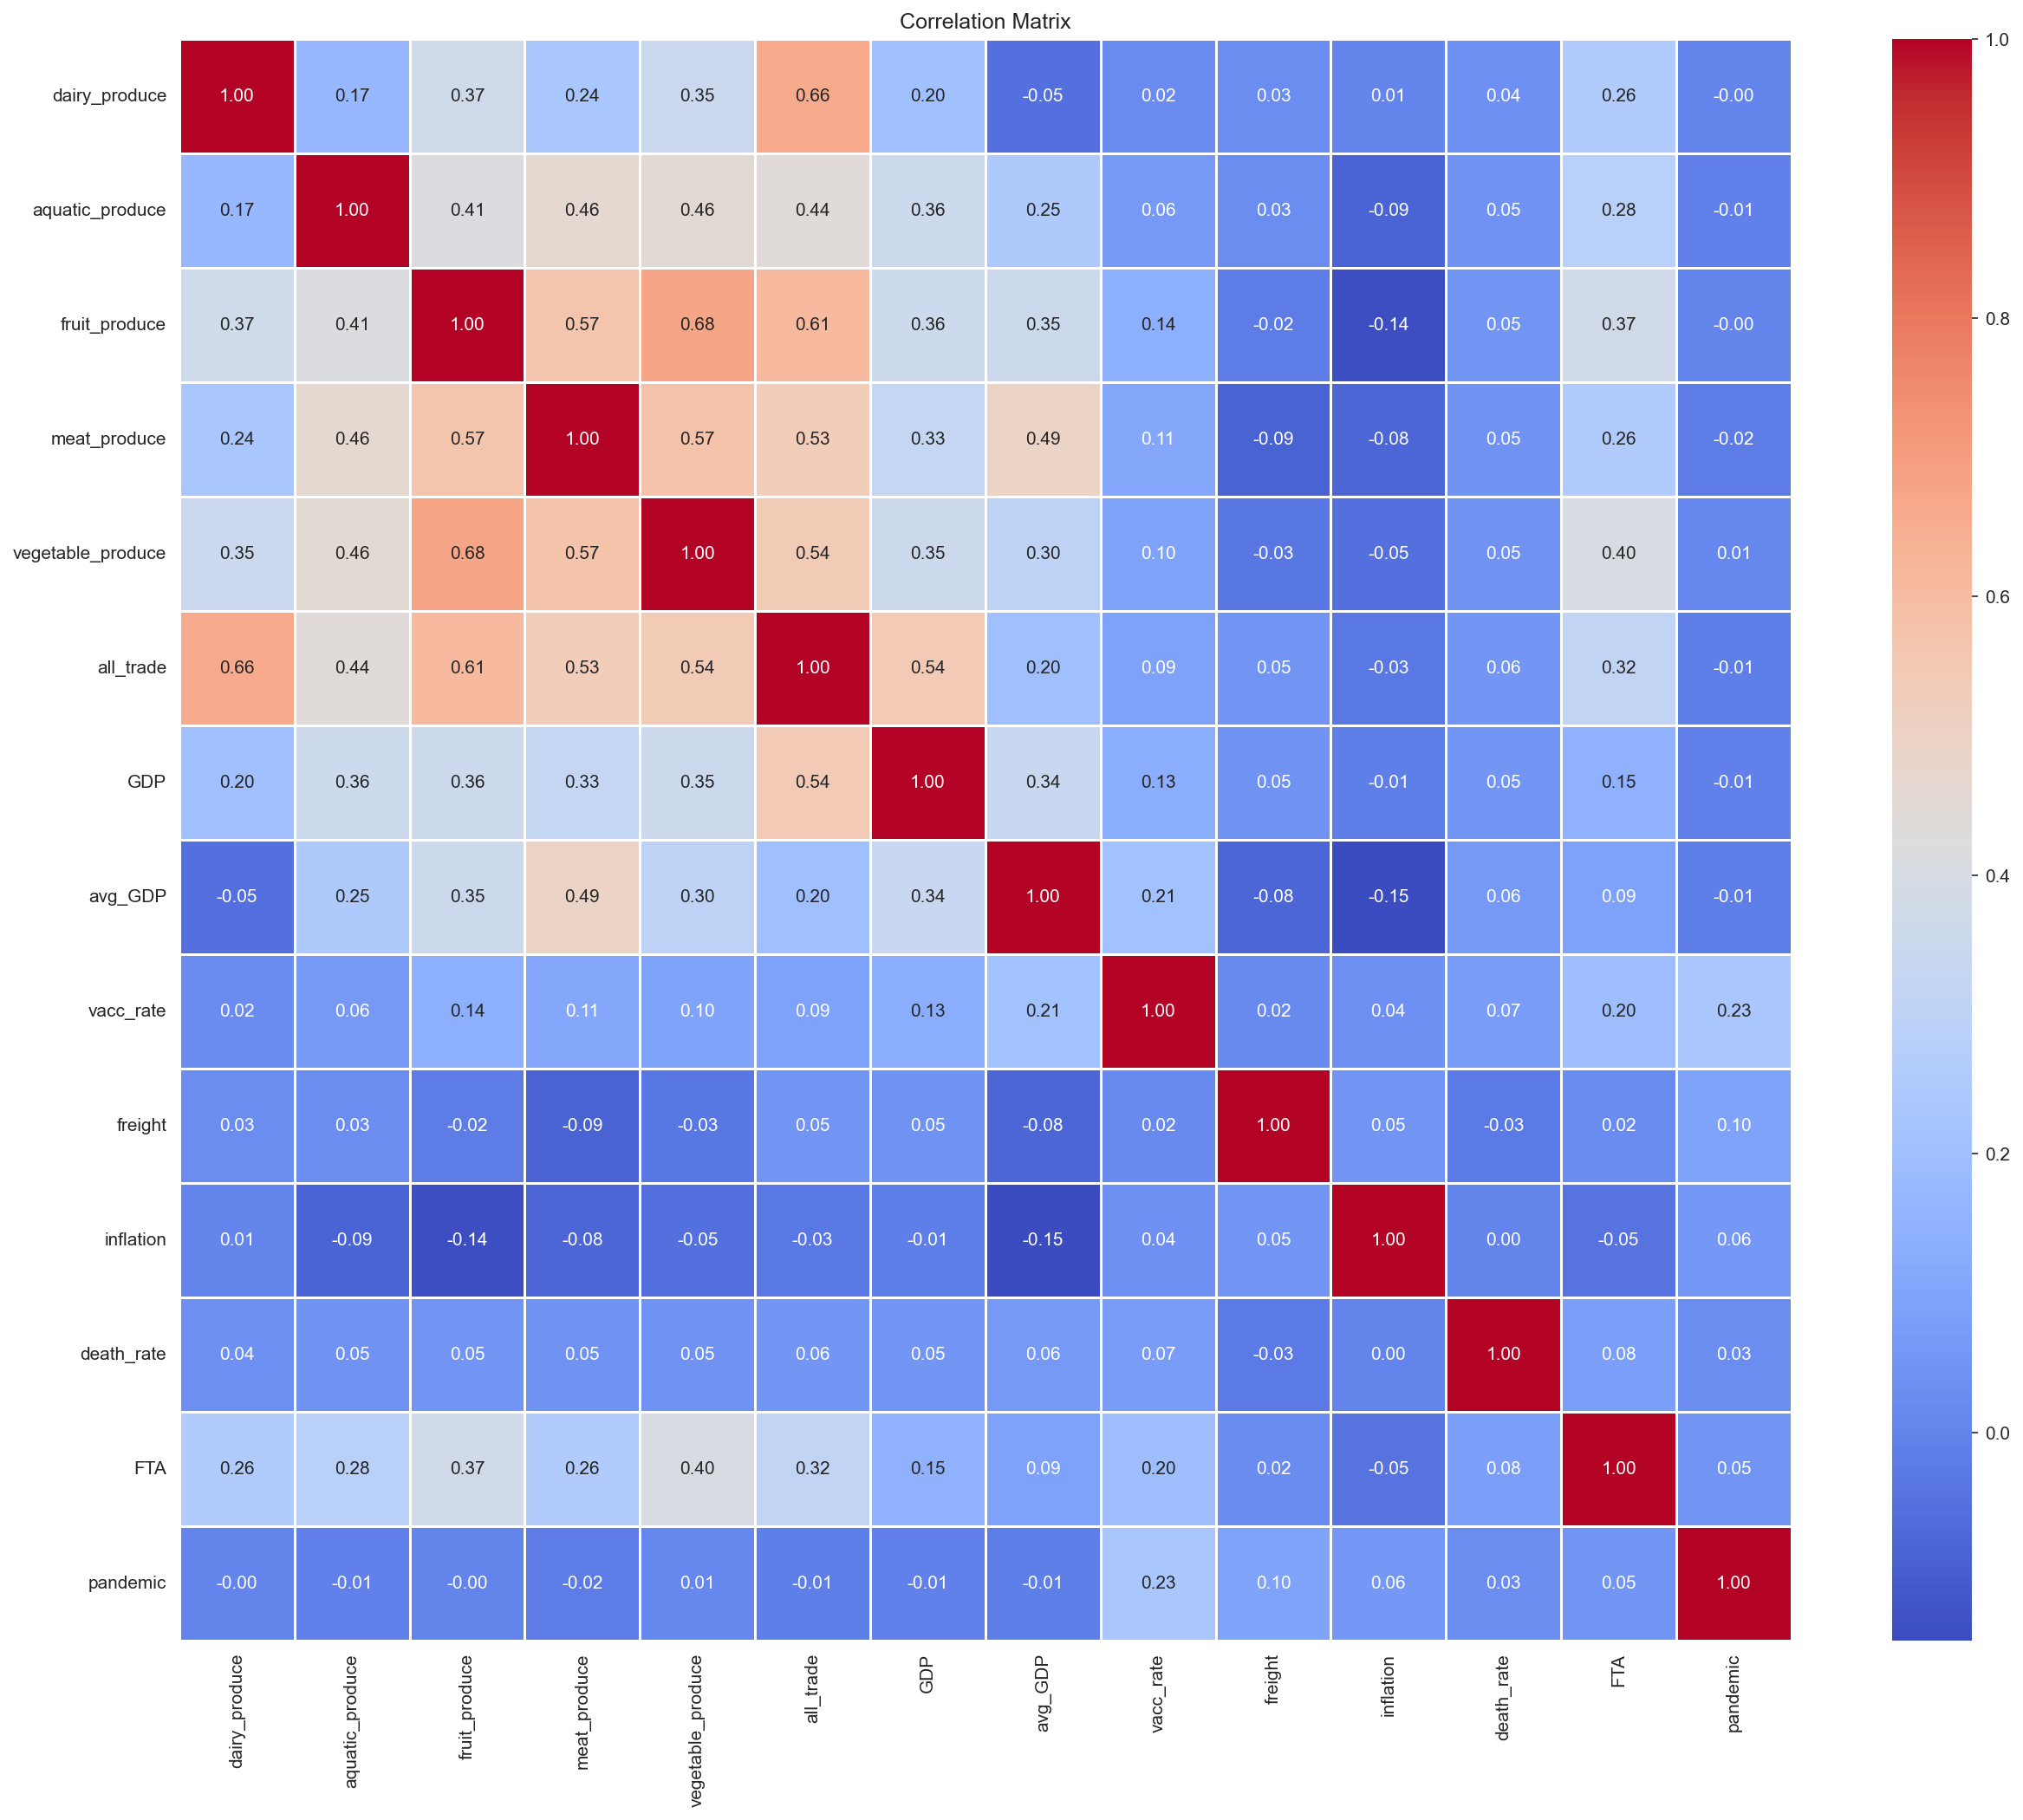

In [16]:
correlation_df = final_data.drop(columns=['year', 'country'])
corr_matrix = correlation_df.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Data Distribution

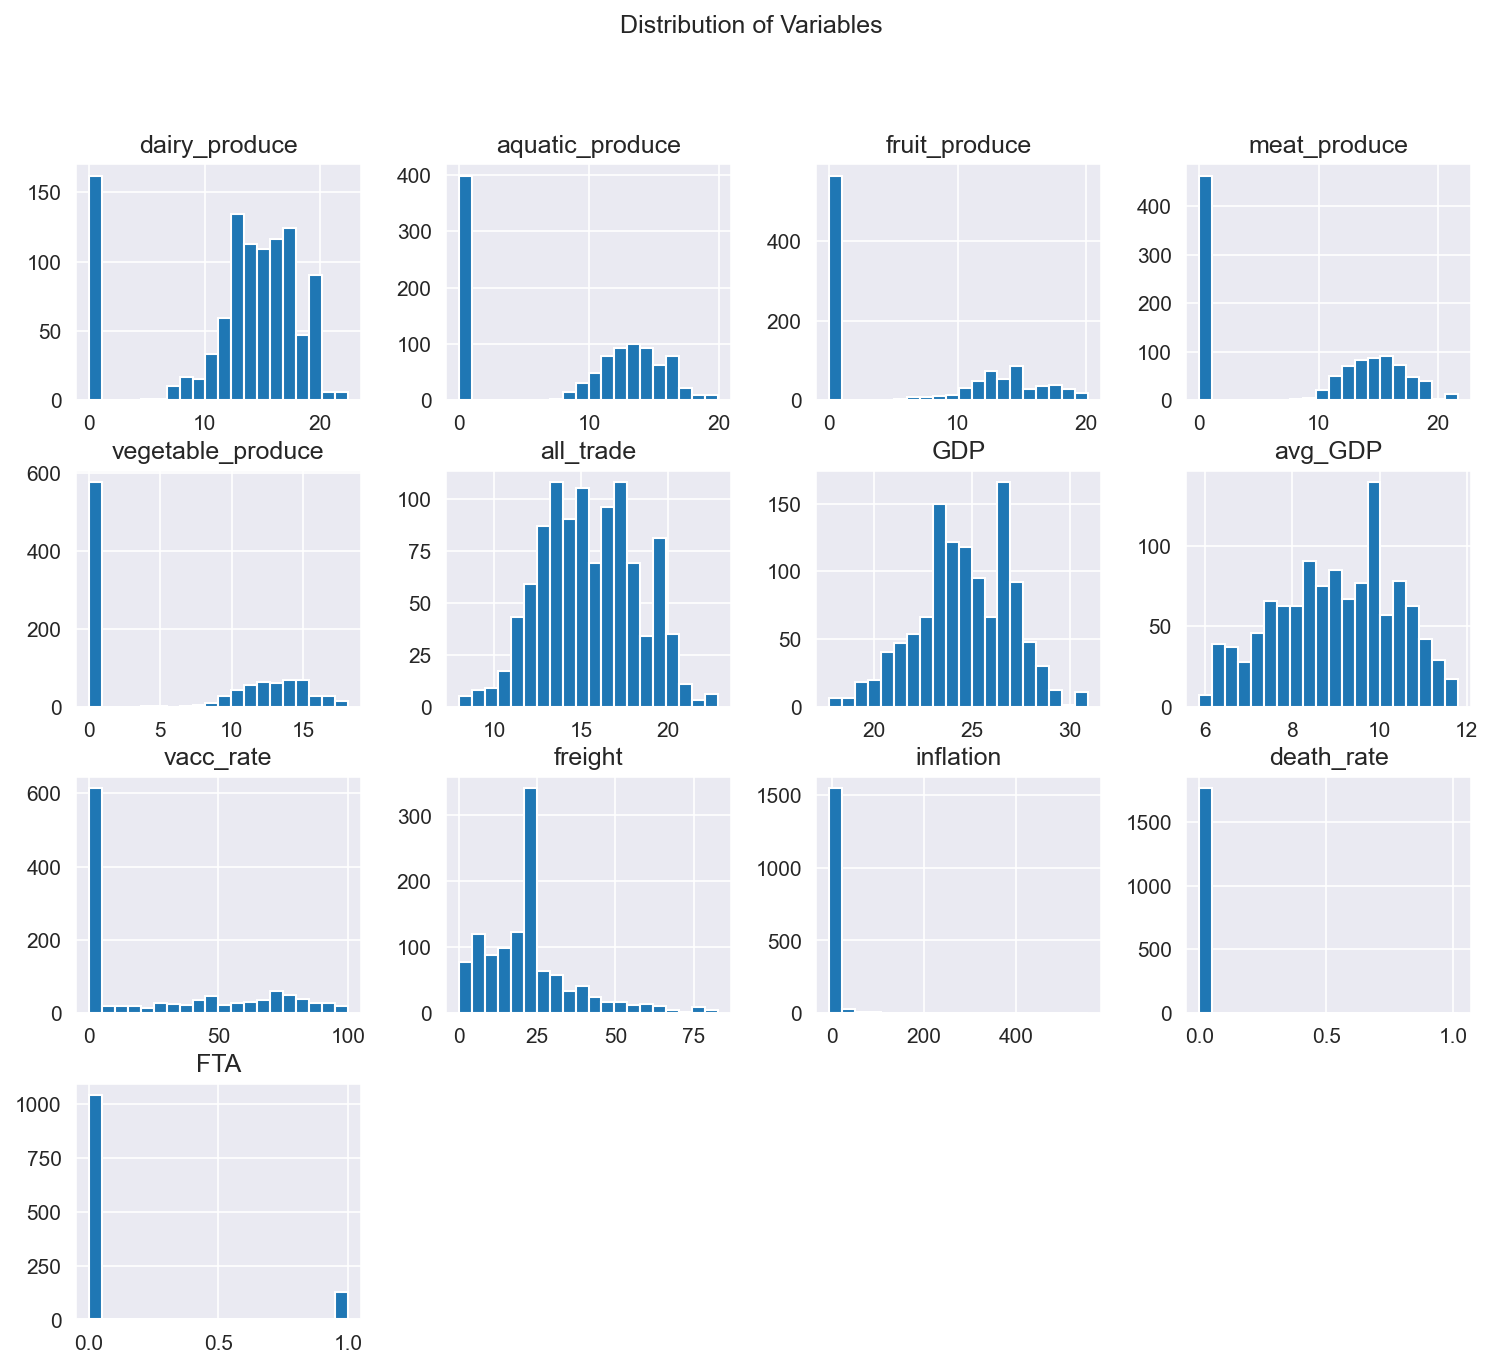

In [17]:
distribution_df = final_data.drop(columns=['year', 'country', 'pandemic'])
distribution_df.hist(bins=20, figsize=(12, 10))
plt.suptitle('Distribution of Variables')
plt.show()

### Time Series Plot

/var/folders/_t/5xwcj3s913b6rjc1d1nq30m80000gn/T/ipykernel_33254/3987964217.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  final_data.groupby('year').sum().drop(columns=['pandemic', 'FTA']).plot(subplots=True, figsize=(20, 15), layout=(4, 3), sharex=False)


array([[<AxesSubplot: xlabel='year'>, <AxesSubplot: xlabel='year'>,
        <AxesSubplot: xlabel='year'>],
       [<AxesSubplot: xlabel='year'>, <AxesSubplot: xlabel='year'>,
        <AxesSubplot: xlabel='year'>],
       [<AxesSubplot: xlabel='year'>, <AxesSubplot: xlabel='year'>,
        <AxesSubplot: xlabel='year'>],
       [<AxesSubplot: xlabel='year'>, <AxesSubplot: xlabel='year'>,
        <AxesSubplot: xlabel='year'>]], dtype=object)

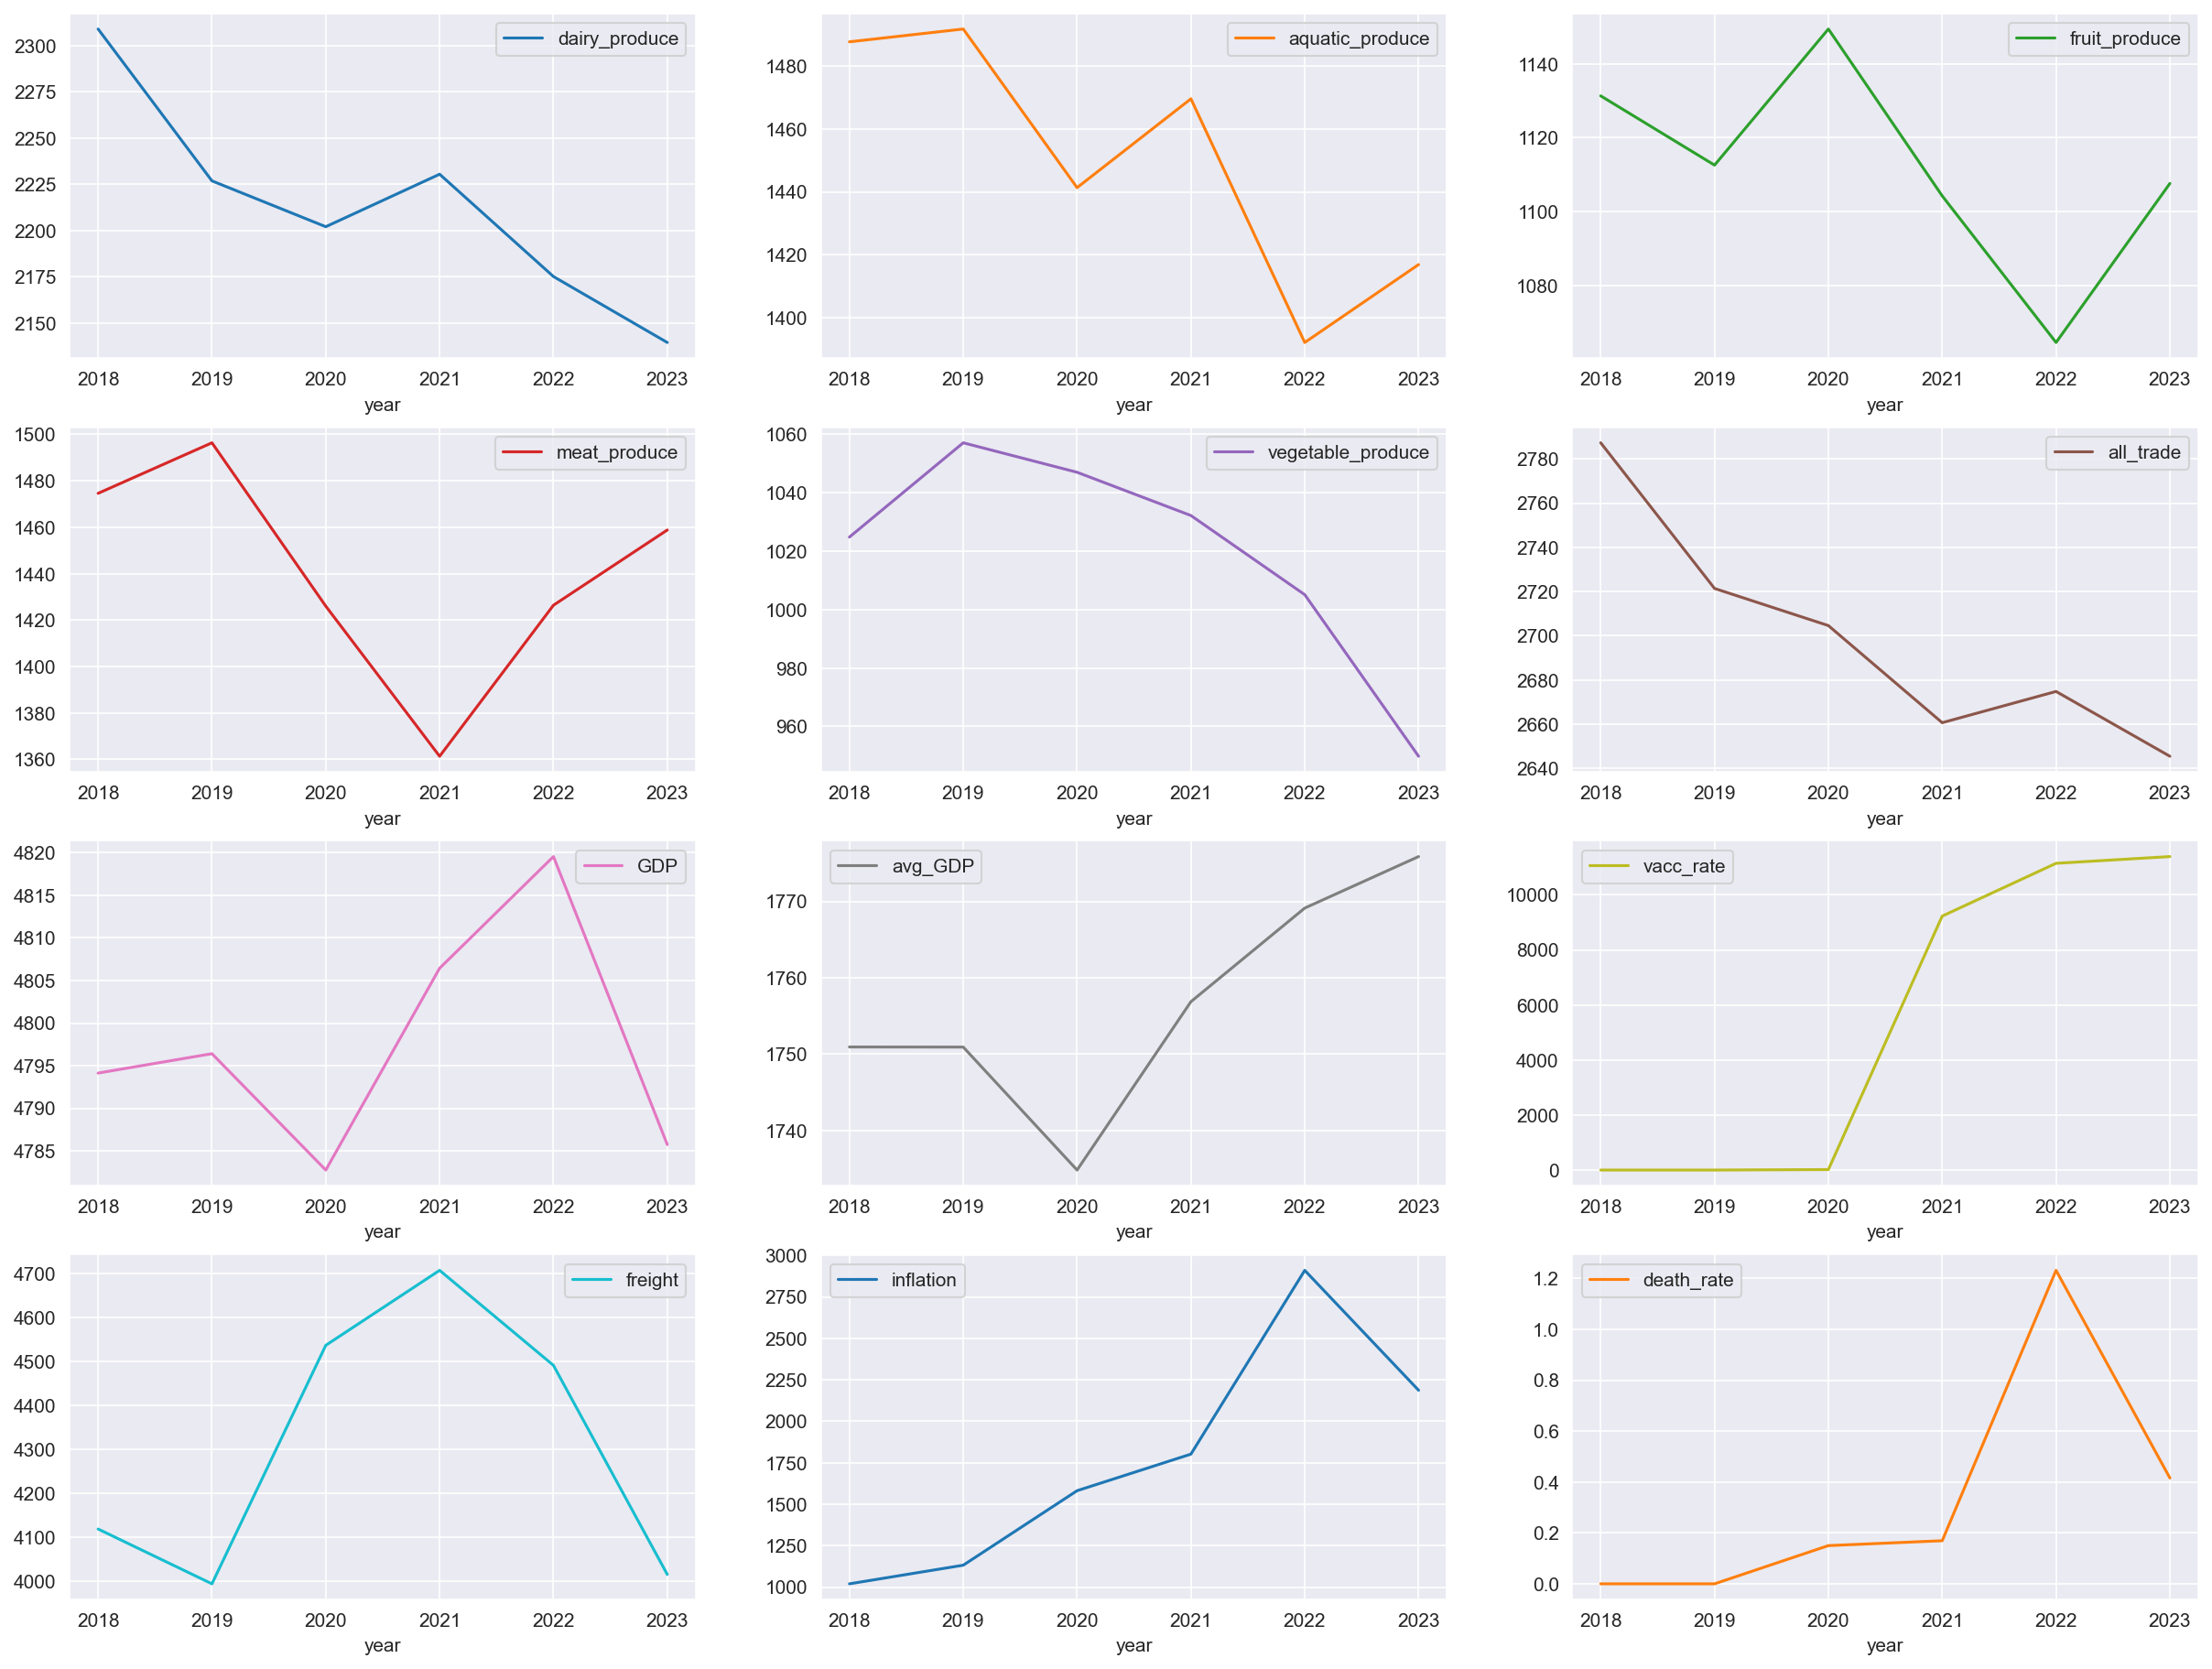

In [18]:
final_data.groupby('year').sum().drop(columns=['pandemic', 'FTA']).plot(subplots=True, figsize=(20, 15), layout=(4, 3), sharex=False)

### Regression

#### Multicollinearity analysis

In [19]:
targets = list(all_trade_value.columns)[2:]
targets

['dairy_produce',
 'aquatic_produce',
 'fruit_produce',
 'meat_produce',
 'vegetable_produce',
 'all_trade']

In [20]:
final_data = final_data.dropna()

X_collinear = final_data.drop(columns=['country', 'year']+targets)
X_collinear = sm.add_constant(X_collinear)
vif_data = pd.DataFrame()
vif_data["feature"] = X_collinear.columns
vif_data["VIF"] = [variance_inflation_factor(X_collinear.values, i) for i in range(X_collinear.shape[1])]
vif_data

,feature,VIF
0,const,130.398730
1,GDP,1.141025
2,avg_GDP,1.219710
3,vacc_rate,1.175865
4,freight,1.026325
5,inflation,1.057031
6,death_rate,1.016547
7,FTA,1.064785
8,pandemic,1.079300


###### All variables except the const has VIF less than 10, so no Multicollinearity problems

## stat OLS (for regression summary)

### Dairy produce

In [21]:
X = final_data.drop(columns=['country', 'year'] + targets)
y = final_data['dairy_produce']


scaler = StandardScaler()
X_standard = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_ols = sm.add_constant(X_standard)
y_ols = list(y)
model_diary = sm.OLS(y_ols, X_ols).fit()
model_diary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     15.72
Date:                Fri, 23 Aug 2024   Prob (F-statistic):           7.18e-22
Time:                        23:28:25   Log-Likelihood:                -2968.7
No. Observations:                 941   AIC:                             5955.
Df Residuals:                     932   BIC:                             5999.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7796      0.186     68.761      0.000      12.415      13.144
GDP            1.3188      0.199      6.643      0.000       0.929       1.708
avg_GDP       -0.8193      0.205     -3.992      0.000      -1.222      -0.416
vacc_rate     -0.2086      0.202     -1.035      0.301      -0.604       0.187
freight        0.0150      0.188      0.080      0.937      -0.355       0.385
inflation      0.0175      0.191      0.092      0.927      -0.357       0.393
death_rate     0.0926      0.187      0.494      0.621      -0.275       0.460
FTA            1.4939      0.192      7.789      0.000       1.117       1.870
pandemic      -0.0651      0.193     -0.337      0.736      -0.444       0.314
==============================================================================
Omnibus:                      170.995   Durbin-Watson:                   2.221
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              269.596
Skew:                          -1.282   Prob(JB):                     2.87e-59
Kurtosis:                       3.553   Cond. No.                         1.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Hypothesis test check whether linear regression works (Diary Produce)
##### 1 & 3. Linearity and  Homoscedasticity (residual plot)

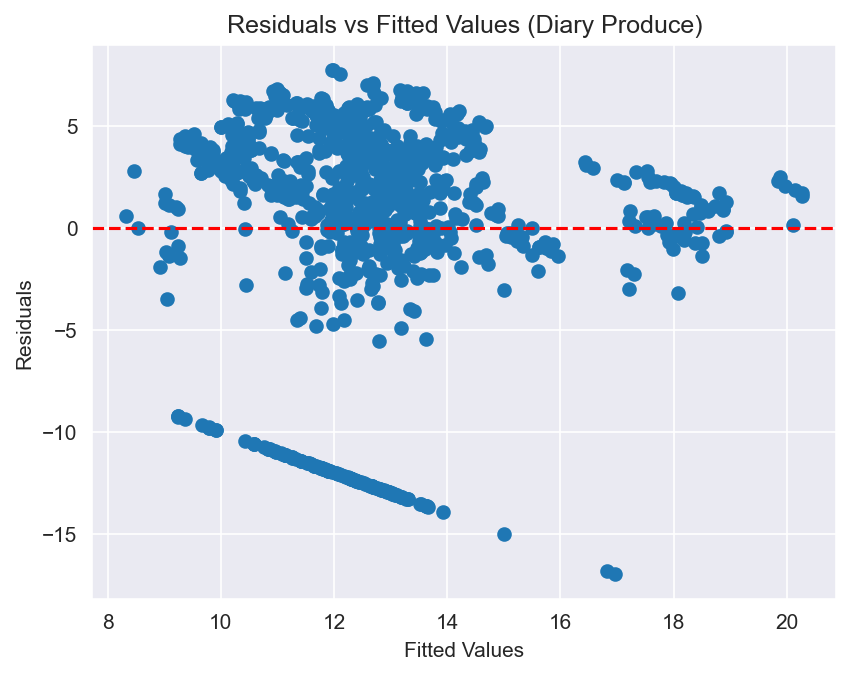

In [22]:
# feature = ['GDP', 'vacc_rate', 'freight', 'inflation', 'death_rate']
# target = 'dairy_produce'
# scatter_plot = sns.pairplot(final_data, x_vars=feature, y_vars=target, kind='scatter')
# scatter_plot.fig.set_size_inches(30, 6)
# plt.show()

plt.scatter(model_diary.fittedvalues, model_diary.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Diary Produce)')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

##### 2. Normality of Errors (Histogram of Residuals and Q-Q plot)

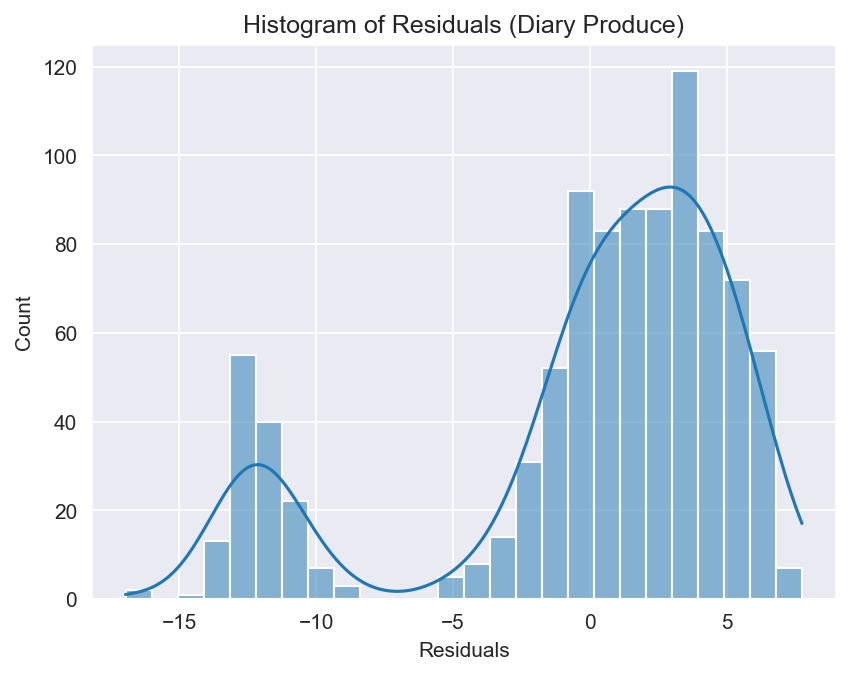

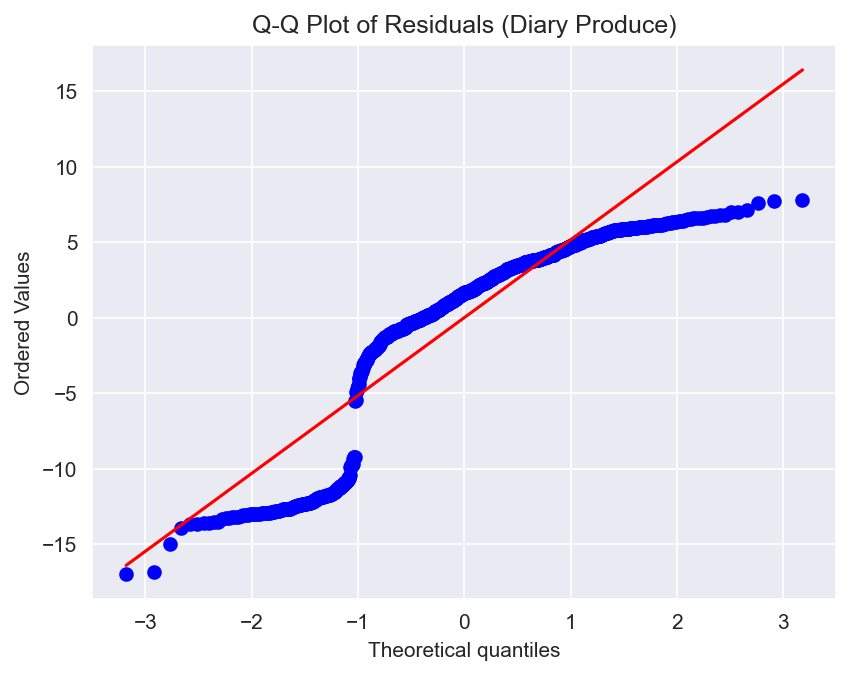

In [23]:
# standard residuals
sns.histplot(model_diary.resid, kde=True)
plt.title('Histogram of Residuals (Diary Produce)')
plt.xlabel('Residuals')
plt.show()

# Q-Q plot
stats.probplot(model_diary.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Diary Produce)')
plt.show()

### Aquatic produce

In [24]:
y = final_data['aquatic_produce']
scaler = StandardScaler()
X_standard = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_ols = sm.add_constant(X_standard)
y_ols = list(y)
model_aquatic = sm.OLS(y_ols, X_ols).fit()
model_aquatic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     31.53
Date:                Fri, 23 Aug 2024   Prob (F-statistic):           5.62e-44
Time:                        23:28:26   Log-Likelihood:                -3036.3
No. Observations:                 941   AIC:                             6091.
Df Residuals:                     932   BIC:                             6134.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2497      0.200     41.308      0.000       7.858       8.642
GDP            2.0850      0.213      9.774      0.000       1.666       2.504
avg_GDP        0.9126      0.221      4.138      0.000       0.480       1.345
vacc_rate     -0.3393      0.217     -1.567      0.117      -0.764       0.086
freight        0.1623      0.202      0.802      0.423      -0.235       0.559
inflation     -0.2394      0.205     -1.166      0.244      -0.642       0.164
death_rate     0.0359      0.201      0.178      0.859      -0.359       0.431
FTA            1.6140      0.206      7.832      0.000       1.210       2.018
pandemic       0.0048      0.207      0.023      0.982      -0.402       0.412
==============================================================================
Omnibus:                     3433.293   Durbin-Watson:                   2.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.534
Skew:                          -0.231   Prob(JB):                     1.46e-17
Kurtosis:                       1.672   Cond. No.                         1.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Hypothesis test check whether linear regression works (Diary Produce)
##### 1. Linearity and  Homoscedasticity (residual plot)

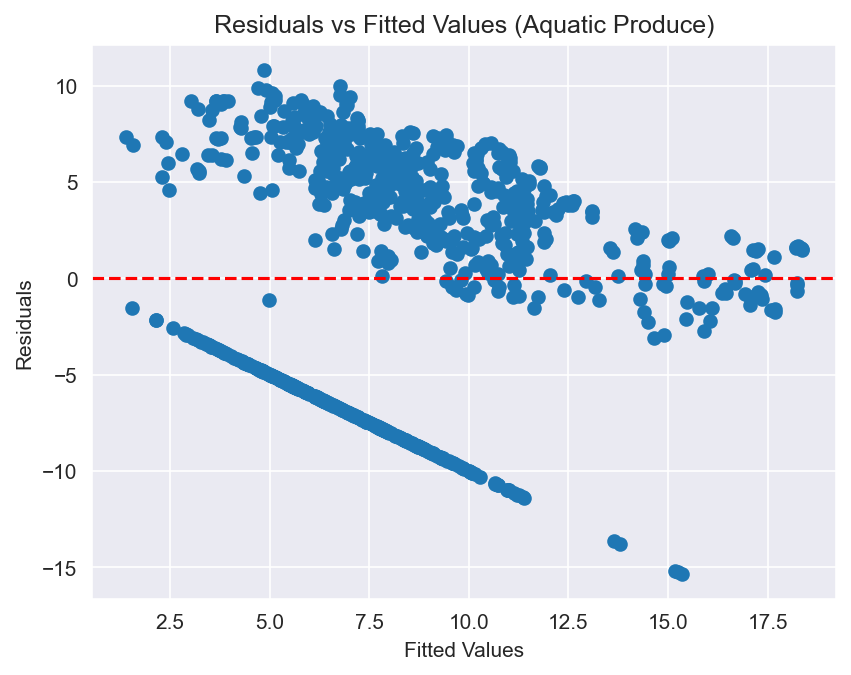

In [25]:
plt.scatter(model_aquatic.fittedvalues, model_aquatic.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Aquatic Produce)')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

##### 2. Normality of Errors (Histogram of Residuals and Q-Q plot)

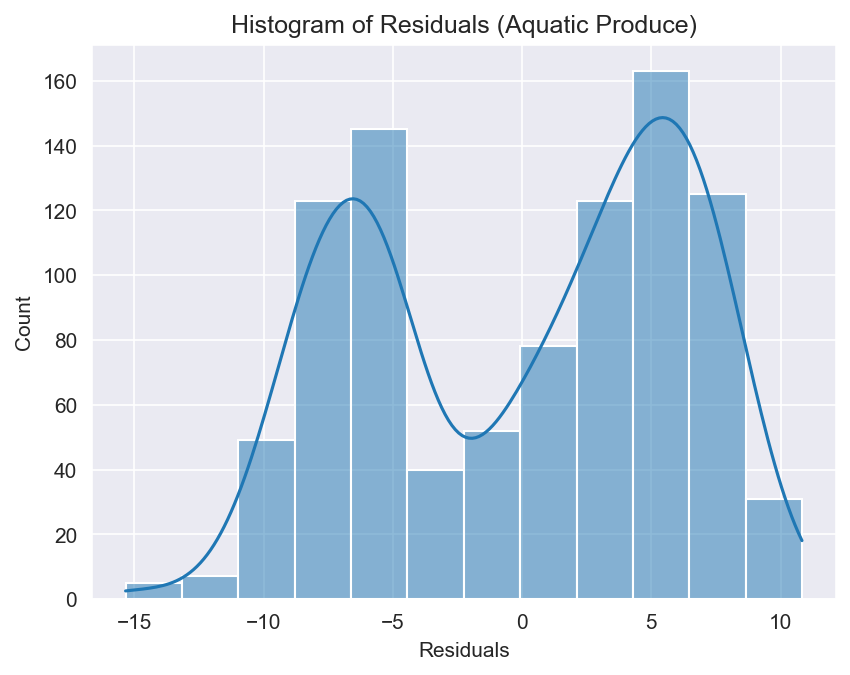

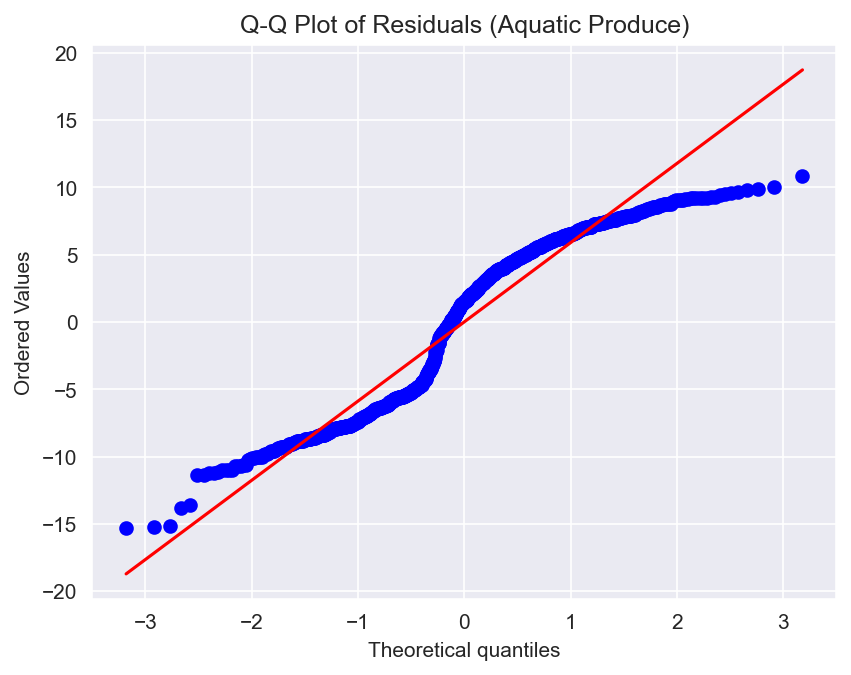

In [26]:
# standard residuals
sns.histplot(model_aquatic.resid, kde=True)
plt.title('Histogram of Residuals (Aquatic Produce)')
plt.xlabel('Residuals')
plt.show()

# Q-Q plot
stats.probplot(model_aquatic.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Aquatic Produce)')
plt.show()

### Fruit produce

In [27]:
y = final_data['fruit_produce']
scaler = StandardScaler()
X_standard = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_ols = sm.add_constant(X_standard)
y_ols = list(y)
model_fruit = sm.OLS(y_ols, X_ols).fit()
model_fruit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     47.80
Date:                Fri, 23 Aug 2024   Prob (F-statistic):           1.12e-64
Time:                        23:28:26   Log-Likelihood:                -3019.8
No. Observations:                 941   AIC:                             6058.
Df Residuals:                     932   BIC:                             6101.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0318      0.196     30.737      0.000       5.647       6.417
GDP            1.4640      0.210      6.984      0.000       1.053       1.875
avg_GDP        1.6591      0.217      7.655      0.000       1.234       2.084
vacc_rate      0.1235      0.213      0.581      0.562      -0.294       0.541
freight       -0.1686      0.199     -0.848      0.397      -0.559       0.222
inflation     -0.5993      0.202     -2.970      0.003      -0.995      -0.203
death_rate    -0.0312      0.198     -0.158      0.875      -0.420       0.357
FTA            2.3577      0.202     11.643      0.000       1.960       2.755
pandemic      -0.0481      0.204     -0.236      0.813      -0.448       0.352
==============================================================================
Omnibus:                      289.089   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.809
Skew:                           0.247   Prob(JB):                     2.07e-12
Kurtosis:                       1.937   Cond. No.                         1.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Hypothesis test check whether linear regression works (Fruit Produce)
##### 1. Linearity and  Homoscedasticity (residual plot)

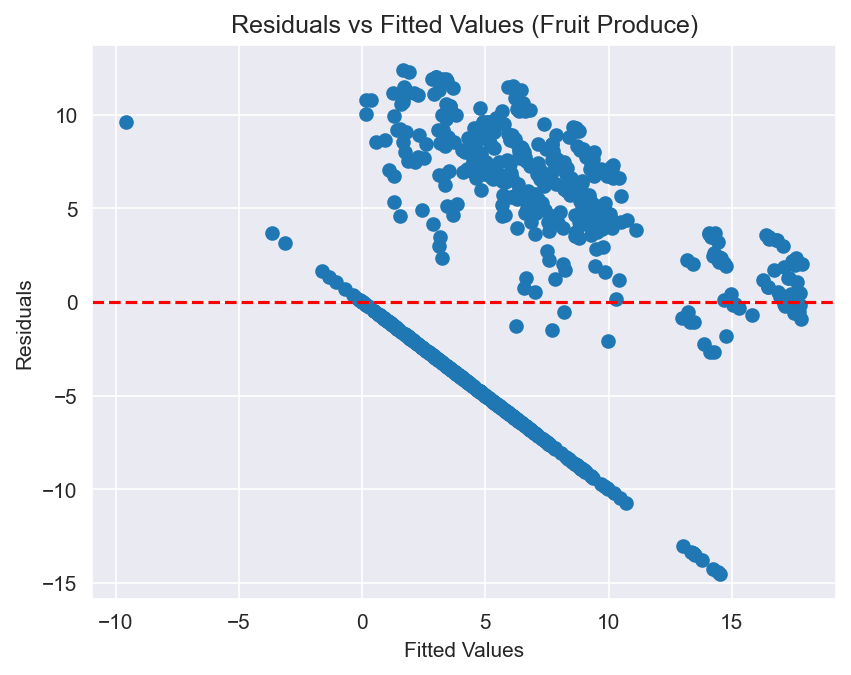

In [28]:
plt.scatter(model_fruit.fittedvalues, model_fruit.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Fruit Produce)')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

##### 2. Normality of Errors (Histogram of Residuals and Q-Q plot)

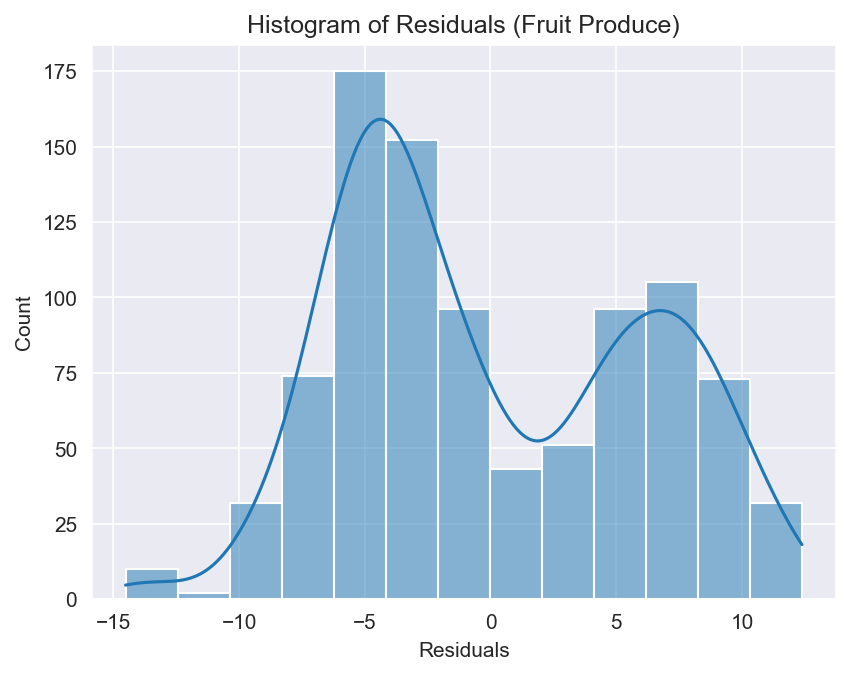

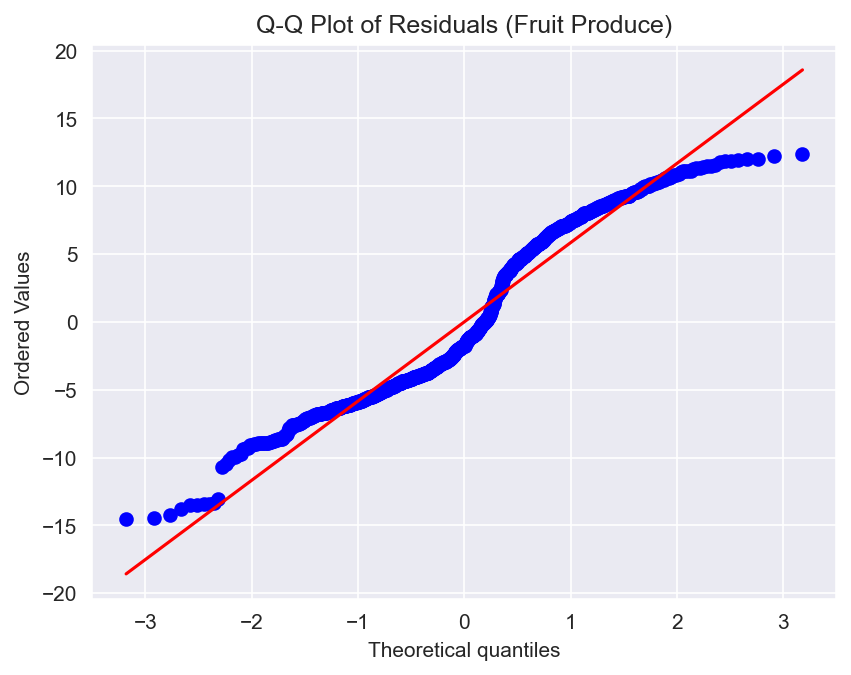

In [29]:
# standard residuals
sns.histplot(model_fruit.resid, kde=True)
plt.title('Histogram of Residuals (Fruit Produce)')
plt.xlabel('Residuals')
plt.show()

# Q-Q plot
stats.probplot(model_fruit.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Fruit Produce)')
plt.show()

### Meat Produce

In [30]:
y = final_data['meat_produce']
scaler = StandardScaler()
X_standard = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_ols = sm.add_constant(X_standard)
y_ols = list(y)
model_meat = sm.OLS(y_ols, X_ols).fit()
model_meat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     51.76
Date:                Fri, 23 Aug 2024   Prob (F-statistic):           2.00e-69
Time:                        23:28:27   Log-Likelihood:                -3080.5
No. Observations:                 941   AIC:                             6179.
Df Residuals:                     932   BIC:                             6223.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.9871      0.209     38.158      0.000       7.576       8.398
GDP            1.1853      0.224      5.301      0.000       0.747       1.624
avg_GDP        3.2720      0.231     14.154      0.000       2.818       3.726
vacc_rate     -0.3440      0.227     -1.515      0.130      -0.789       0.101
freight       -0.5535      0.212     -2.610      0.009      -0.970      -0.137
inflation      0.0603      0.215      0.280      0.779      -0.362       0.483
death_rate    -0.0450      0.211     -0.213      0.831      -0.459       0.369
FTA            1.6121      0.216      7.464      0.000       1.188       2.036
pandemic      -0.0202      0.217     -0.093      0.926      -0.447       0.407
==============================================================================
Omnibus:                      159.703   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.304
Skew:                          -0.133   Prob(JB):                     4.81e-09
Kurtosis:                       2.048   Cond. No.                         1.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Hypothesis test check whether linear regression works (Meat Produce)
##### 1. Linearity and  Homoscedasticity (residual plot)

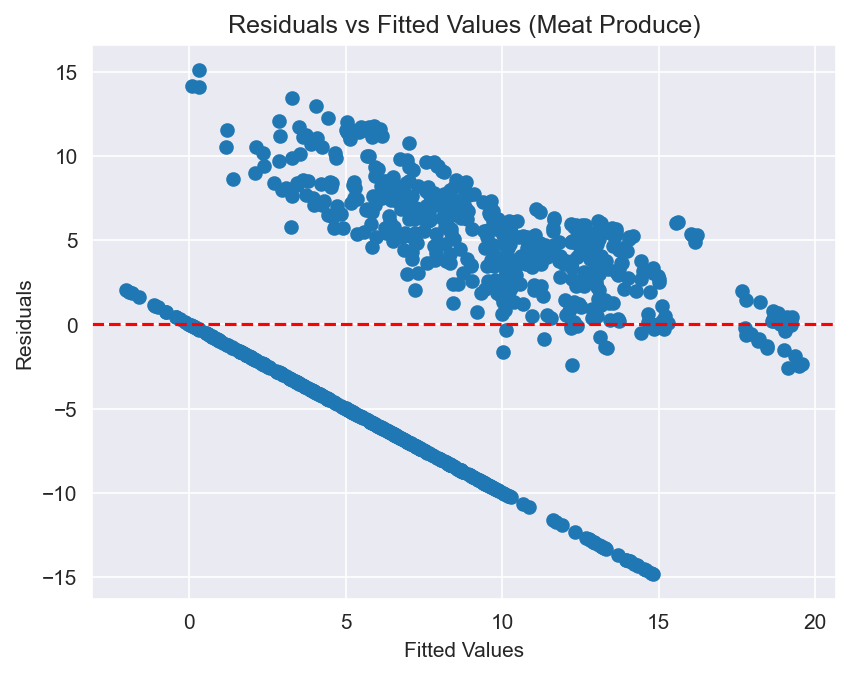

In [31]:
plt.scatter(model_meat.fittedvalues, model_meat.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Meat Produce)')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

##### 2. Normality of Errors (Histogram of Residuals and Q-Q plot)

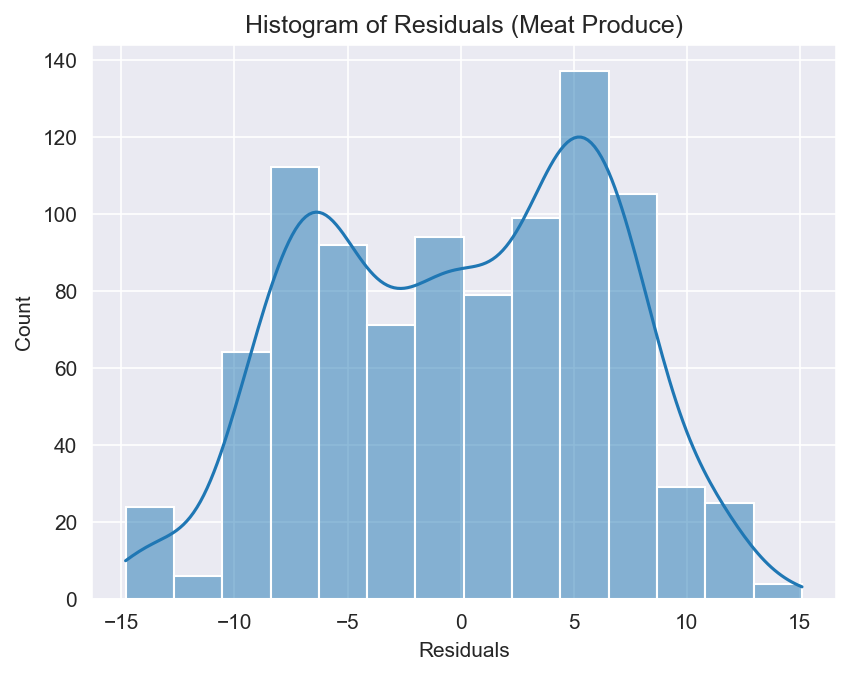

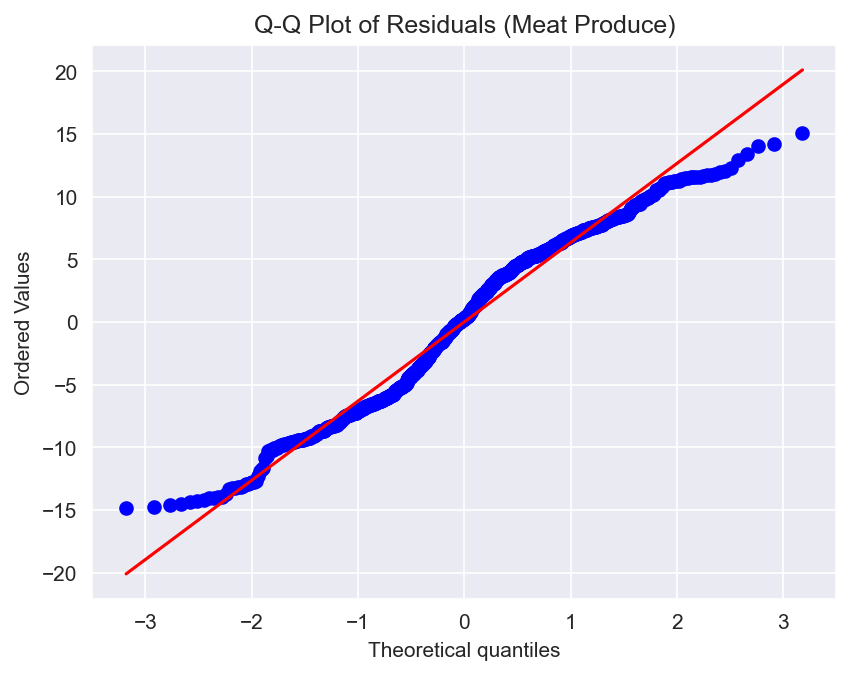

In [32]:
# standard residuals
sns.histplot(model_meat.resid, kde=True)
plt.title('Histogram of Residuals (Meat Produce)')
plt.xlabel('Residuals')
plt.show()

# Q-Q plot
stats.probplot(model_meat.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Meat Produce)')
plt.show()

### Vegetable Produce

In [33]:
y = final_data['vegetable_produce']
scaler = StandardScaler()
X_standard = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_ols = sm.add_constant(X_standard)
y_ols = list(y)
model_vegetable = sm.OLS(y_ols, X_ols).fit()
model_vegetable.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     46.94
Date:                Fri, 23 Aug 2024   Prob (F-statistic):           1.26e-63
Time:                        23:28:28   Log-Likelihood:                -2963.1
No. Observations:                 941   AIC:                             5944.
Df Residuals:                     932   BIC:                             5988.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5970      0.185     30.295      0.000       5.234       5.960
GDP            1.6440      0.197      8.331      0.000       1.257       2.031
avg_GDP        1.2770      0.204      6.258      0.000       0.877       1.677
vacc_rate     -0.2967      0.200     -1.481      0.139      -0.690       0.097
freight       -0.2980      0.187     -1.592      0.112      -0.665       0.069
inflation      0.0922      0.190      0.485      0.628      -0.281       0.465
death_rate    -0.0510      0.186     -0.274      0.784      -0.417       0.315
FTA            2.4544      0.191     12.875      0.000       2.080       2.828
pandemic       0.1061      0.192      0.553      0.581      -0.271       0.483
==============================================================================
Omnibus:                      154.365   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.578
Skew:                           0.573   Prob(JB):                     1.93e-18
Kurtosis:                       2.124   Cond. No.                         1.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Hypothesis test check whether linear regression works (Vegetable Produce)
##### 1. Linearity and  Homoscedasticity (residual plot)

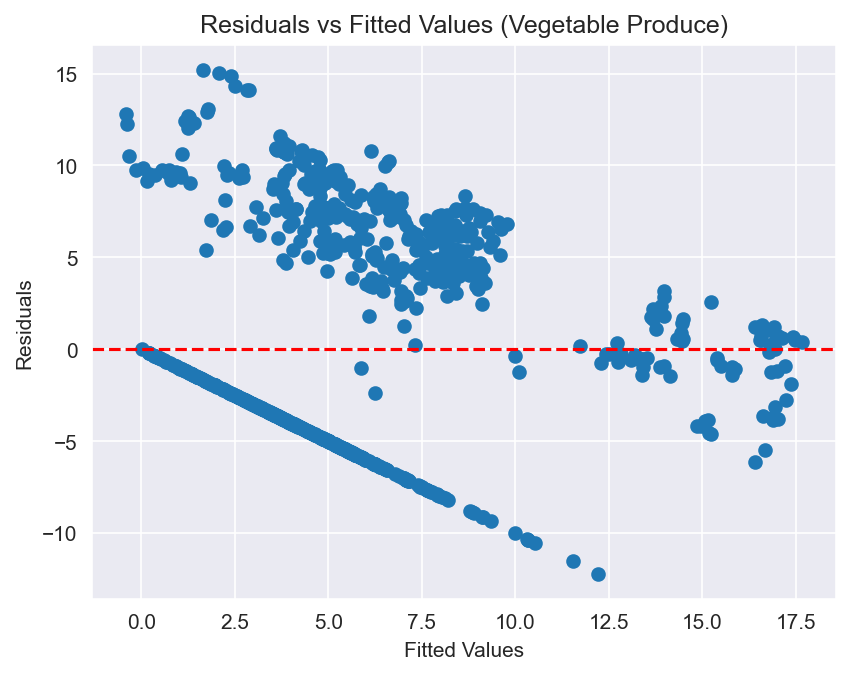

In [34]:
plt.scatter(model_vegetable.fittedvalues, model_vegetable.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Vegetable Produce)')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

##### 2. Normality of Errors (Histogram of Residuals and Q-Q plot)

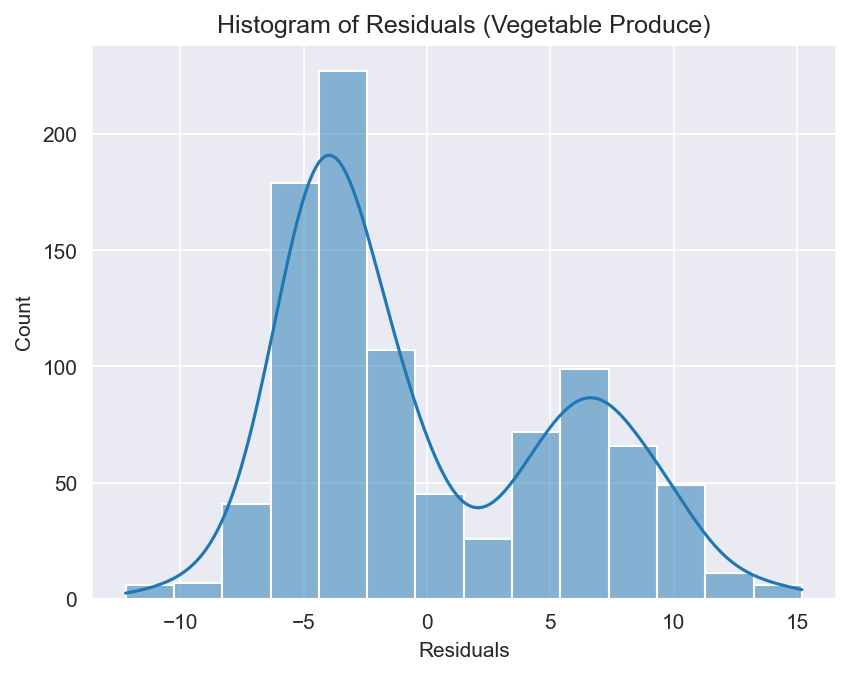

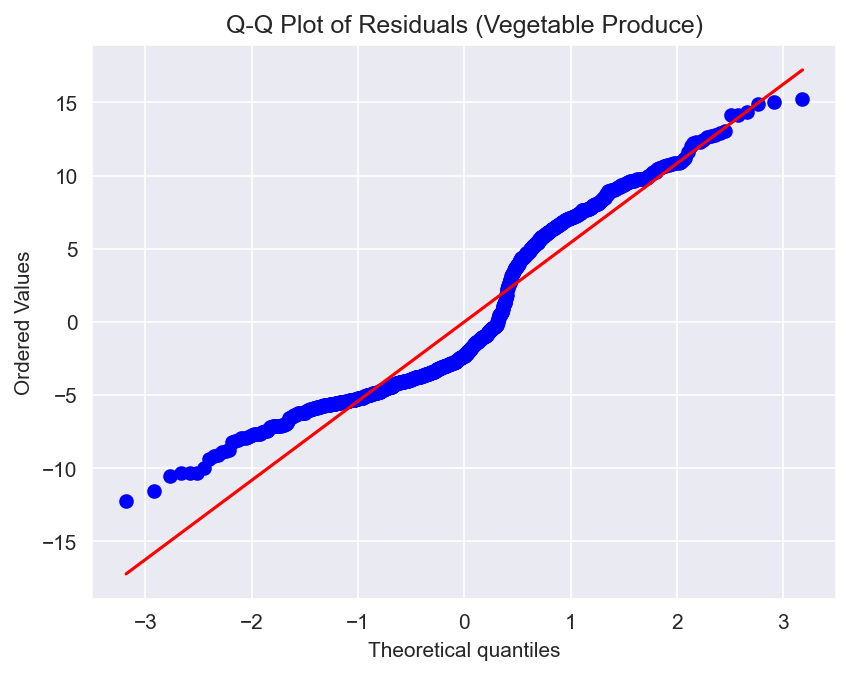

In [35]:
# standard residuals
sns.histplot(model_vegetable.resid, kde=True)
plt.title('Histogram of Residuals (Vegetable Produce)')
plt.xlabel('Residuals')
plt.show()

# Q-Q plot
stats.probplot(model_vegetable.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Vegetable Produce)')
plt.show()

### All trade

In [36]:
y = final_data['all_trade']
scaler = StandardScaler()
X_standard = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_ols = sm.add_constant(X_standard)
y_ols = list(y)
model_all = sm.OLS(y_ols, X_ols).fit()
model_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     73.15
Date:                Fri, 23 Aug 2024   Prob (F-statistic):           2.40e-93
Time:                        23:28:28   Log-Likelihood:                -2037.5
No. Observations:                 941   AIC:                             4093.
Df Residuals:                     932   BIC:                             4137.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.5160      0.069    224.572      0.000      15.380      15.652
GDP            1.3780      0.074     18.672      0.000       1.233       1.523
avg_GDP        0.0788      0.076      1.033      0.302      -0.071       0.229
vacc_rate     -0.0867      0.075     -1.157      0.247      -0.234       0.060
freight        0.0696      0.070      0.994      0.320      -0.068       0.207
inflation      0.0124      0.071      0.174      0.862      -0.127       0.152
death_rate     0.0142      0.070      0.204      0.838      -0.123       0.151
FTA            0.7340      0.071     10.296      0.000       0.594       0.874
pandemic      -0.0295      0.072     -0.411      0.681      -0.170       0.111
==============================================================================
Omnibus:                       53.955   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.952
Skew:                          -0.601   Prob(JB):                     3.53e-14
Kurtosis:                       3.366   Cond. No.                         1.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Hypothesis test check whether linear regression works (Fruit Produce)
##### 1. Linearity and  Homoscedasticity (residual plot)

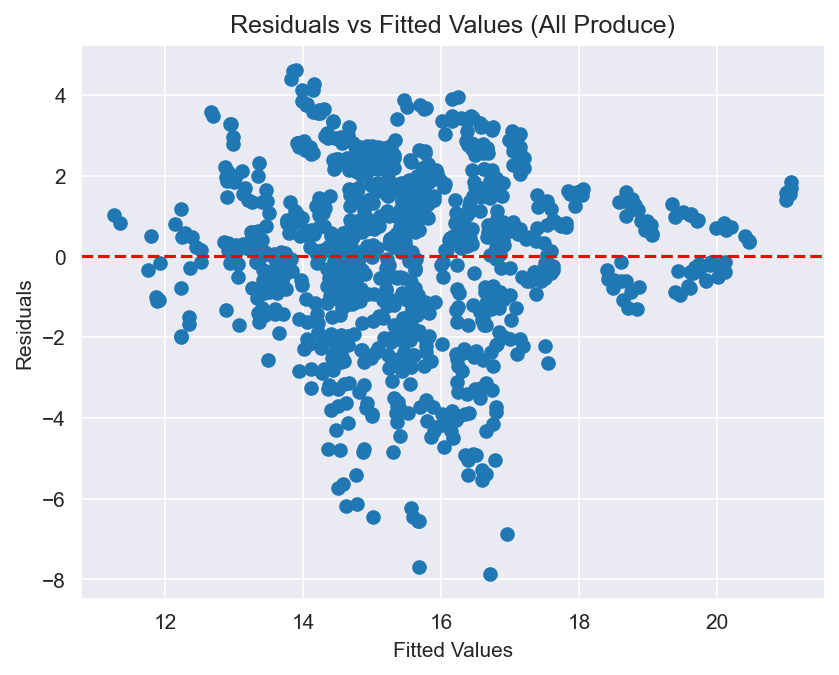

In [37]:
plt.scatter(model_all.fittedvalues, model_all.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (All Produce)')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

##### 2. Normality of Errors (Histogram of Residuals and Q-Q plot)

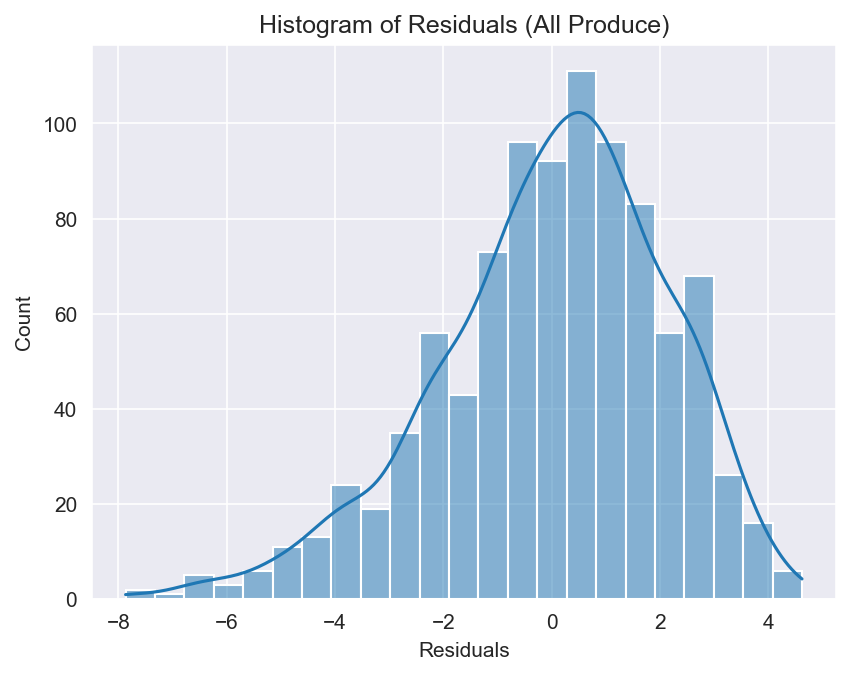

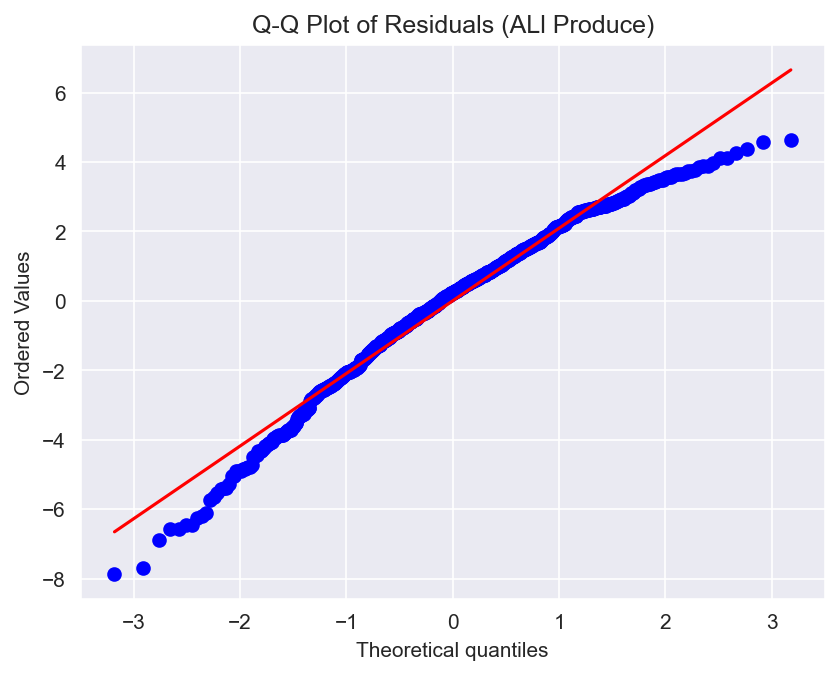

In [38]:
# standard residuals
sns.histplot(model_all.resid, kde=True)
plt.title('Histogram of Residuals (All Produce)')
plt.xlabel('Residuals')
plt.show()

# Q-Q plot
stats.probplot(model_all.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (ALl Produce)')
plt.show()

### 1. What factors affect New Zealand's food exports? And how?

### 2. Can Free Trade Agreement (FTA) help New Zealand export more food to its trade partners?

### 3. How has COVID-19 affected New Zealand exports? (e.g. overall vs. each export item)

### 4. Can FTA offset the negative effect of COVID-19 on New Zealand exports? Or Can FTA boost the positive effect of COVID-19 on New Zealand exports? If so, how?